# Special Fourier Transforms

Specific input properties can be exploited in order to enhance computation efficiency. Especially symmetries as even, odd or real symmtery are used in these examples.
The vectorised implementation, which has been introduced in the previous chapter is imported from "FFT_vec_implementation.py"

In [1]:
import FFT_vec_implementation as FFT



## Fast Real DFT

Computation of a real-valued DFT using complex FFT is inefficient, because N redundant com- ponents would be computed. In the following possibilities will be introduced in order to improve efficiency.

### Two Real DFTs from one complex FFT

1. construct vector $f_n$ from two real vectors $g_n, h_n$ as $f_n = g_n + i h_n$.

2. compute $F_k$ from the FFT

3. compute $G_k, H_k$ according to:
\begin{gather}
G_k = \frac{1}{2} (F_k + F_{-k}^*), \quad H_k = - \frac{i}{2} (F_k - F_{-k}^*)
\end{gather}


In [2]:
import numpy as np
import time

g = np.random.randn(2**12)
h = np.random.randn(2**12)

t = time.time()
f = np.array(g+1J*h)
F = FFT.fft(f.copy())
G_1c = np.array(0.5*(F+np.conjugate(F[-np.arange(0,np.size(F))])))
H_2c = -1J/2*(F-np.conjugate(F[-np.arange(0,np.size(F))]))
elapsed = time.time()-t

print('Elapsed time 2 real DFT from 1 complex FFT: ',elapsed)

t = time.time()
G_2c = FFT.fft(g)
H_2c = FFT.fft(h)
elapsed = time.time()-t

print('Elapsed time 2 complex FFTs: ',elapsed)


Elapsed time 2 real DFT from 1 complex FFT:  0.41980910301208496
Elapsed time 2 complex FFTs:  0.8257808685302734


### Real 2N DFT from complex N FFT

1. set $z_n = f_{2n} + if_{2n−1}$

2. compute $Z_k$ from FFT applied on $z_n$

3. compute $F_k$ according to the newly derived butterfly scheme: 
\begin{gather}
F_k = \frac{1}{4} Z_k(1- i \omega_{2N}^k) + \frac{1}{4} Z_{-k}^*(1+ i \omega_{2N}^k), \quad k = 0, \dotsb, \frac{N}{2}\\
F_{k+N} = \frac{1}{4} Z_k(1+ i \omega_{2N}^k) + \frac{1}{4} Z_{-k}^*(1- i \omega_{2N}^k), \quad k = -\frac{N}{2}+1, \dotsb ,0
\end{gather}

We obtain $2$ times faster computation with this butterfly scheme. 

Elapsed Time 2 * N complex FFTs:  0.3864619731903076
Elapsed Time 1 * 2N real FFT: 0.8620967864990234


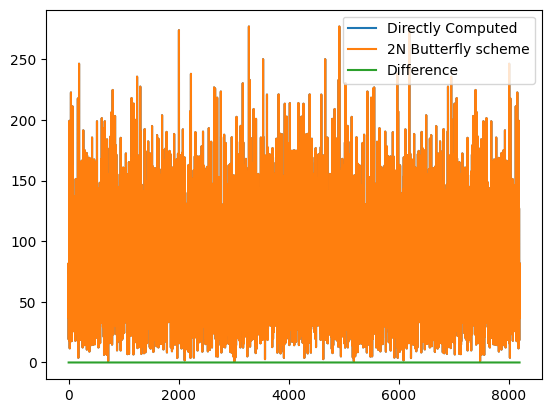

In [3]:
import matplotlib.pyplot as plt

f = np.random.randn(2**13)

def real2NDFT(f):
    N = np.size(f)
    n = np.arange(0,np.int_(N/2))

    z = f[2*n]+1J*f[2*n-1]
    Z = FFT.fft(z)
    F = np.array(np.zeros((np.size(f),)),np.complex_)

    k = np.arange(0,np.int_(N/2))
    F[k] = 1/2*Z[k]*(1-1J*np.exp(1J*2*np.pi*k/(N))) + 1/2*np.conjugate(Z[-k])*(1+1J*np.exp(1J*2*np.pi*k/(N)))
    k = np.arange(-np.int_(N/2)+1,1)
    F[np.int_(N/2)-k] = 1/2*Z[k]*(1+1J*np.exp(1J*2*np.pi*k/(N))) + 1/2*np.conjugate(Z[-k])*(1-1J*np.exp(1J*2*np.pi*k/(N)))

    return F

t = time.time() # 2N Real DFTs in 2 N complex DFTs
F = real2NDFT(f)
elapsed = time.time()-t
print('Elapsed Time 2 * N complex FFTs: ',elapsed)

t = time.time() # 1 2N complex DFT

F2 = FFT.fft(f.copy())

elapsed = time.time()-t
print('Elapsed Time 1 * 2N real FFT:', elapsed)

plt.figure()
plt.plot(np.abs(F2))
plt.plot(np.abs(F))
plt.plot(np.abs(F2)-np.abs(F))
plt.legend(['Directly Computed','2N Butterfly scheme','Difference'])
plt.show()

## Quater Wave DFT on even Symmetric Data

The QW-DFT on even Symmetric data is the QW-DCT: 
\begin{gather}
\tilde F_k = \frac{1}{N} \sum_{n=0}^{N-1} f_n \cos\left( \frac{\pi k(n+1/2)}{N} \right)
\end{gather}

The QW-DCT coefficients are shifted by a quarter wave with respect to the DFT cefficients:
\begin{gather}
F_k = \tilde F_k \omega_N^{k/2} = \tilde F_k e^{i\pi k/N}
\end{gather}

The QW-DCT can be computed by a 2N-real DFT:

1. Extend the data as:
\begin{gather}
g_n = f_n \land g_{2N-n-1} = f_n, \quad n = 0, \dotsb, N-1
\end{gather}

2. Compute the 2N-Real-FFT compute $G_k$ from $g_n$ for $k = 0, \dotsb,N$.

3. Apply the relation between the QW and DFT coefficients:
\begin{gather}
\tilde F_k = G_ke^{-i\pi k/(2N)}
\end{gather}


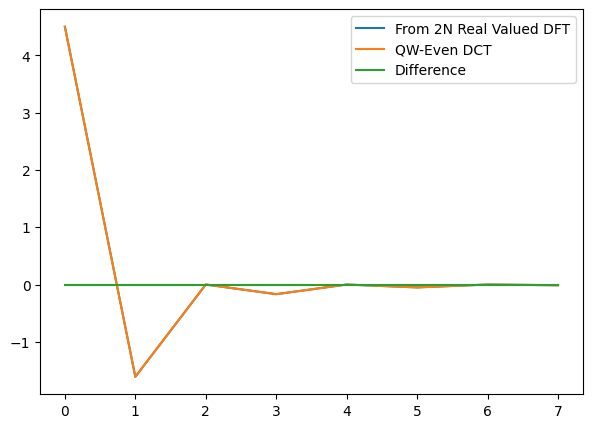

Computed DCT coeffcients:
[ 4.50000000e+00 -1.61058076e+00 -6.66133815e-16 -1.68363700e-01
 -9.71445147e-17 -5.02257259e-02 -6.10622664e-16 -1.26755807e-02]
Converted DCT coefficients:
[ 4.5       +0.00000000e+00j -1.61058076-5.55111512e-17j
  0.        +0.00000000e+00j -0.1683637 +2.77555756e-17j
  0.        +0.00000000e+00j -0.05022573+4.16333634e-17j
  0.        +0.00000000e+00j -0.01267558-4.77048956e-17j]


In [4]:
f = np.array([1,2,3,4,5,6,7,8])
N = np.size(f)

# Simple implementation of the QW Even Discrete Cosine Transform
F_DCT = np.array(1/N * np.array([np.sum([f[n]*np.cos((np.pi*k*(n+0.5))/N) for n in range(0,N)]) for k in range(0,N)]))

# Simple implementation of the inverse QW Even Discrete Cosine Transform
f_rec = np.array( F2[0] + 2* np.array([np.sum([F[k]*np.cos((np.pi*k*(n+0.5))/N) for k in range(0,N)]) for n in range(0,N)]))

# Extend Data
f_expand = np.append(f,np.flip(f))

# Compute the real 2N DFT
F = real2NDFT(f_expand)

# Convert the N DFT coefficients into the N DCT coefficients
F_tilde = 1/(2*N)*F[range(0,N)]*np.exp(-1J*np.pi*np.arange(0,N)/(2*N))

plt.figure(figsize=(7,5))
plt.plot(np.real(F_tilde))
plt.plot(F_DCT)
plt.plot(np.real(F_tilde)-F_DCT)
plt.legend(['From 2N Real Valued DFT','QW-Even DCT','Difference'])
plt.show()

print('Computed DCT coeffcients:')
print(F_DCT)
print('Converted DCT coefficients:')
print(F_tilde)

### DFT on Odd Symmetric Data

The DFT on odd symmetric data yields the Discrete Sine Transform (DST), given by: 
\begin{gather}
F_k = \frac{-i}{N} \sum_{n=1}^{N-1} f_n \sin \left( \frac{\pi nk}{N}\right), \quad k = 1, \dotsb, N-1
\end{gather}

It can be computed effeiciently by exploiting symmetry and performing a 2N real valued DFT. 

1. Expand the data such that:
\begin{gather}
x_{-k} = -x_k, \quad k = 1, \dotsb, N-1\\
x_0 = x_k = 0
\end{gather}

2. Compute the real valued 2N DFT

3. Use the conversion between DST and DFT coefficients:
\begin{gather}
\hat X_k = - Im\{X_k\}, \quad k = 1, \dotsb, N-1
\end{gather}

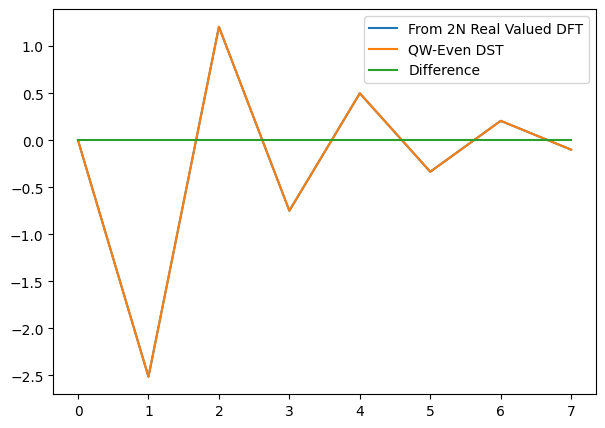

Computed DST coeffcients:
[0.-0.j         0.-2.51366975j 0.+1.20710678j 0.-0.74830288j
 0.+0.5j        0.-0.33408932j 0.+0.20710678j 0.-0.09945618j]
Converted DST coefficients:
[ 0.+0.j         -0.-2.51366975j  0.+1.20710678j -0.-0.74830288j
  0.+0.5j        -0.-0.33408932j  0.+0.20710678j -0.-0.09945618j]


In [ ]:
f = np.array([0,1,2,3,4,5,6,7])
N = np.size(f)

# Simple implementation of the QW Even Discrete Cosine Transform
F_DST = np.array(-1J/N * np.array([np.sum([f[n]*np.sin((np.pi*k*n)/N) for n in range(0,N)]) for k in range(0,N)]))

# Simple implementation of the inverse QW Even Discrete Cosine Transform
f_rec = 2J* np.array([np.sum([F[k]*np.sin((np.pi*k*n)/N) for k in range(0,N)]) for n in range(0,N)])

# Extend Data
f_expand = np.append(f,0)
f_expand = np.append(f_expand,np.flip(-f[1:]))

# Compute the real 2N DFT
F = FFT.fft(f_expand)

# Convert the N DFT coefficients into the N DST coefficients
F_tilde = 1J/(2*N)*np.imag(F[range(0,N)])

plt.figure(figsize=(7,5))
plt.plot(np.imag(F_tilde))
plt.plot(np.imag(F_DST))
plt.plot(np.imag(F_tilde-(F_DST)))
plt.legend(['From 2N Real Valued DFT','QW-Even DST','Difference'])
plt.show()

print('Computed DST coeffcients:')
print(F_DST)
print('Converted DST coefficients:')
print(F_tilde)